# What's this?

This notebook describes an analysis of measurements taken from a Core417I board (the one like [Core 407I](http://www.waveshare.com/wiki/Core407I) but featuring a version of the STM32F4 chip with HW crypto accelerator). The board together with a custom sofware package is available from Riscure as a training target dubbed [Piñata](https://www.riscure.com/product/pinata-training-target/). Since vanilla Piñata software doesn't do HMAC SHA1, I (@ceesb) cut and paste some of ST's reference code. Then, I added a command on the Piñata that feeds back a SHA1 output into the HMAC SHA1 computation so that Piñata does many HMACs per input sent from the PC:

```
i = 0
iterations = MSB_UINT32(readfromserial(4))
input = readfromserial(20)
for i < iterations:
   triggerUP()
   output = HMACSHA1(input)
   triggerDOWN()
   input = SHA1(input)
   i++
writetoserial(output)
```

It can be run from the PC by sending a message with command 0xdf:

```
=>   df <UINT32 MSB iterations> <20 bytes MSB input>
<=   <20 bytes output of last HMAC SHA1 iteration>
```

Send me (@ceeesb) a ping for the binary.

# Acquisition

[Riscure EM probe (LS)](https://www.riscure.com/product/em-probe-station/) over the chip, right in the middle.

Picoscope in rapid block mode, 4096 encryptions per scope fetch.  On receiving the 4096 traces on the PC we compute the inputs and store them in a trace set. Since we know the key, we verify that the last HMAC output of the Piñata matches with what we expect, so we know for sure all traces match the inputs. Obviously the acquisition is done with a Julia script, similar to piposcope.jl in Jlsca's example folder, but send me a ping if you want it.

Acquired > 1M traces of 3900 samples at 1Gs/s in *less than 15 minutes*. 3.5Gb 7-zipped trace set [here](https://drive.google.com/open?id=0B-My9BsChztIM21sdWxWRWRrZGs).

# Attack

The attack is the same as described in Section 3.4 in this [paper](https://link.springer.com/chapter/10.1007/978-3-319-25915-4_19) by Belaid and others.

We're going to take a look at SHA1 HMAC using the input. The key itself cannot be recovered since there is no differential data being mixed with the key. The two SHA1 states themselves are sufficient to create arbitrary HMACs. One can also attack the outer SHA1 using an output attack, but this is not shown here (although [Jlsca](https://github.com/Riscure/Jlsca) implements this attack too). We'll only be looking at the inner SHA1.

To explain this attack, we first define some terms:
* a0,b0,c0,d0,e0: the 160-bit SHA1 state we are to recover, in 5 32-bit numbers
* W0 - W3: the attacker controlled and known 32-bit inputs
* T0-T3: the value of T for rounds 0-3
* F0-F3: the output value of the F function for rounds 0-3
* Rot(x,a): rotates x left by a bits
* Ch(a,b,c): the SHA Ch function 

We then roll out first 4 rounds of the inner SHA1 loop in the terms defined above:
```
T0 = Rot(a0, 5) + Ch(b0, c0, d0) + e0 + 0x5a827999 + W0
F0 = Ch(b0, c0, d0)

T1 = Rot(T0, 5) + Ch(a0, Rot(b0, 30), c0) + d0 + 0x5a827999 + W1
F1 = Ch(a0, Rot(b0, 30), c0)

T2 = Rot(T1, 5) + Ch(T0, Rot(a0, 30), Rot(b0, 30)) + c0 + 0x5a827999 + W2
F2 = Ch(T0, Rot(a0, 30), Rot(b0, 30))

T3 = Rot(T2, 5) + Ch(T1, Rot(T0, 30), Rot(a0, 30)) + Rot(b0, 30) + 0x5a827999 + W3
F3 = Ch(T1, Rot(T0, 30), Rot(a0, 30))
```

The SHA1 input attack steps are then:
1. DPA attack on 32-bit modular addition to guess "Rot(a0, 5) + Ch(b0, c0, d0)" and predict "T0" since we know "W0" 
2. DPA attack on 32-bit modular addition to guess "Ch(a0, Rot(b0, 30), c0) + d0" and predict "T1" since we know "W1" and "Rot(T0, 5)" 
3. DPA attack on Ch function to guess "Rot(a0, 30)" and predict "F3" since we know "T1" and "Rot(T0, 30)" 
4. DPA attack on Ch function to guess "Rot(b0, 30)" and predict "F2" since we know "T0" and "Rot(a0, 30)"
5. DPA attack on 32-bit modular addition to guess "c0" and predict "T2" since we know "Rot(T1, 5) + Ch(T0, Rot(a0, 30), Rot(b0, 30))" and "W2" 

These 5 attacks allow us to recover the secret SHA1 state a0,b0,c0,d0,e0. Note that attack n depends on the output of attack n-1 for n > 1. In Jlsca terms we'd call these 5 attack *phases*. Actually, we will be using 8-bit target values, so we need 4 attacks per 32-bit modular addition. Therefore, there are in total 14 phases in the SHA1 input attack: 4 + 4 + 1 + 1 + 4. The attack on a 32-bit Ch output is also implemented by 4 DPA attacks on 8-bit wide target values, but since these are independent of each other they are treated as a single phase.

Note also that this attack only uses 12 bytes of the input! (W0, W1 and W2)

In [1]:
# add two local workers in addition to the master process
addprocs(2)

# import the necessary stuff on each process
@everywhere begin
    using Jlsca.Trs
    using Jlsca.Sca
    using Jlsca.Sca.sca
    using Jlsca.Sca.hw
    using Jlsca.Sha
    using Jlsca.Align
    using ProgressMeter
end

# plotting libs are local only
using PyPlot.plot,PyPlot.figure,PyPlot.title,PyPlot.subplots

using Base.Threads

@printf("#procs:              %d\n", nprocs())
@printf("#workers:            %d\n", nworkers())
@printf("#threads per worker: %d\n", nthreads())

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#procs:              3
#workers:            2
#threads per worker: 10


In [2]:
# open the trace set on all workers. Note that our trace set doesn't have output, only 20 bytes of input.

@everywhere begin
    emulation = false
    
    if emulation
        trs = InspectorTrace("../jlsca/examples/sha1_67452301efcdab8998badcfe10325476c3d2e1f0.trs")
        # 16 bytes input, 20 bytes output in this trace set 
        inputLength = 16
        rangeOfInterest = 1:200
    else
        trs = InspectorTrace("pinatahmacsha1.trs")
        # a dirty hack to make Jlsca interpret this data as signed (don't change this to types with different sizes, or bad fail)
        trs.sampleType = Int8
        # only 20 inputs in this trace set
        inputLength = 20
        rangeOfInterest = 900:2100
    end
    
    getTrs() = trs
end

Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20
	From worker 3:	Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20
	From worker 2:	Opened pinatahmacsha1.trs, #traces 1228800, #samples 3900 (UInt8), #data 20


In [3]:
# sets up a static align pass

if !emulation 
    @everywhere begin
        popSamplePass(trs)

        maxShift = 100
        referenceOffset = 900
        referenceLength = 600
        reference = trs[1][2][referenceOffset:referenceOffset+referenceLength-1]
        corvalMin = 0.0
        alignstate = CorrelationAlignFFT(reference, referenceOffset, maxShift)
        # object "alignpass" caches the shift and correlation values, so that's it's only computed once (per process)
        alignpass = AlignPass(alignstate, length(trs), corvalMin)

        addSamplePass(trs, alignpass)
    end
end

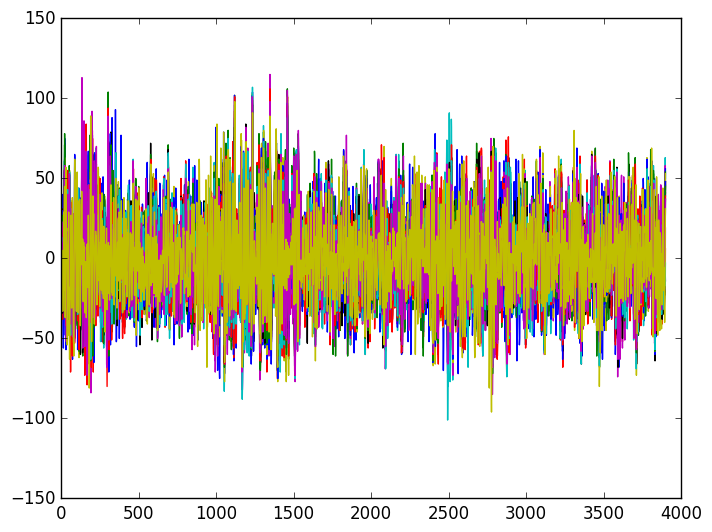

In [4]:
# show a few traces in the same window
for i in 1:20
    plot(trs[i][2])
end

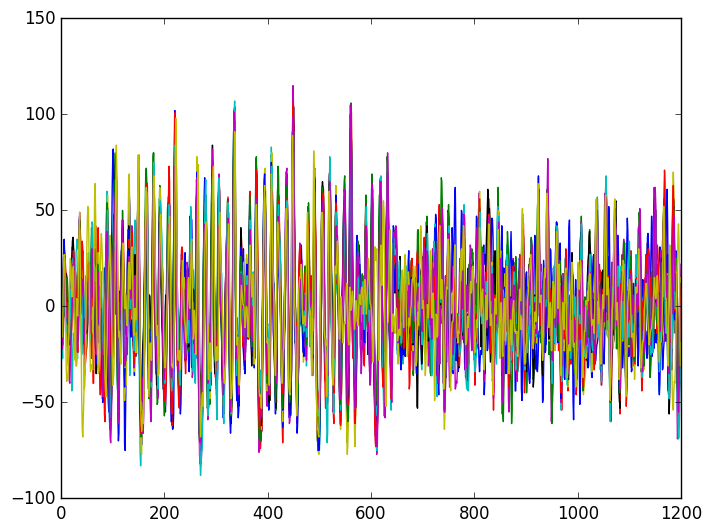

In [5]:
# zoomed in to check the alignment
for i in 1:20
    plot(trs[i][2][rangeOfInterest])
end


In [6]:
# helper functions

@everywhere begin
    innerstate = sha1init()
    if emulation
        knownkeyinner = [0x00 for i in 1:20]
        knownkeyinner = hex2bytes("67452301efcdab8998badcfe10325476c3d2e1f0")
    else
        # the key used for HMAC SHA1 on the pinata
        key = hex2bytes("cafebabedeadbeef0001020304050607cafebabedeadbeef")
        innerkey = Sha.K0(key) .⊻ 0x36
        update(innerstate, innerkey)
        # the secret state of the inner SHA1
        knownkeyinner = reinterpret(UInt8, map(hton, innerstate.H))
        @assert innerstate.rnd == 1 && innerstate.free == 64
        outerstate = sha1init()
        outerkey = Sha.K0(key) .⊻ 0x5c
        update(outerstate, outerkey)
        # the secret state of the outer SHA1
        knownkeyouter = reinterpret(UInt8, map(hton, outerstate.H))
    end

    # computes the output the inner SHA1
    function inneroutput(innerstate::Sha1state, msg::Vector{UInt8})
        state = deepcopy(innerstate)
        update(state, msg)
        return final(state)
    end

    # given the known inner SHA1 key computes the HD between 0,T0 T0,T1 T1,T2, T2,T3
    function attackableHDT(msg::Vector{UInt8})
        data = zeros(UInt32, 4)
        cnt = Ref(1)
        innerstate2 = deepcopy(innerstate)
        update(innerstate2, msg[1:inputLength])
        final(innerstate2, (x,y) -> x == "T" && cnt.x <= length(data) ? (data[cnt.x] = y; cnt.x += 1) : nothing)
        xor = 0x00000000
        for i in 1:length(data)
            tmp = data[i]
            data[i] ⊻= xor
            xor = tmp
        end
        return map(hton, data)
    end
    
    # given the known inner SHA1 key computes the HD between T0,W0 T1,W1 T2,W2, T3,W3
    # our trace set doesn't leak this though ..
    function attackableHDIn(msg::Vector{UInt8})
        data = zeros(UInt32, 4)
        cnt = Ref(1)
        innerstate2 = deepcopy(innerstate)
        update(innerstate2, msg[1:inputLength])
        final(innerstate2, (x,y) -> x == "T" && cnt.x <= length(data) ? (data[cnt.x] = y; cnt.x += 1) : nothing)
        for i in 1:length(data)
            data[i] ⊻= Sca.getInt(i,msg)
        end
        return map(hton, data)
    end
end


# Helper for computing correlation. We don't define this in the @everwhere macro, since we only need it on the 
# master process. It uses IncrementalCovarianceTiled which is threaded, and macro @parallel to run it on different
# processes.
function correlateDataSamples()
    @everywhere begin 
        ic = IncrementalCovarianceTiled(length(trs[1][1]), length(trs[1][2]))
        getIc() = ic
    end
    
    @sync @parallel for t in 1:length(trs)
        trs = getTrs()
        ic = getIc()
        (data, samples) = trs[t]
        if length(data) == 0 || length(samples) == 0
            continue
        end
        add!(ic, data, samples)
    end
        
    
    for w in workers()
        if w != myid()
            add!(ic, @fetchfrom w getIc())
        end
    end
    
    C = getCorr(ic)
    return abs.(C)
end

correlateDataSamples (generic function with 1 method)

We first want to determine in time when the inner SHA1 computation is happening. Inner SHA1 consumes the input, the next code block compute the correlation of samples with the HW of the input, and then plot it. We'll see large spikes from around sample 900 onwards.

In [7]:
# byte-wise HW of input correlated with samples
@everywhere begin
    addDataPass(trs, x -> Sca.hw.(x))
    addSamplePass(trs, x -> abs.(x))
end

@time C1 = correlateDataSamples()

@everywhere begin
    popDataPass(trs)
    popSamplePass(trs)
end

113.143818 seconds (1.41 M allocations: 82.504 MiB, 0.03% gc time)


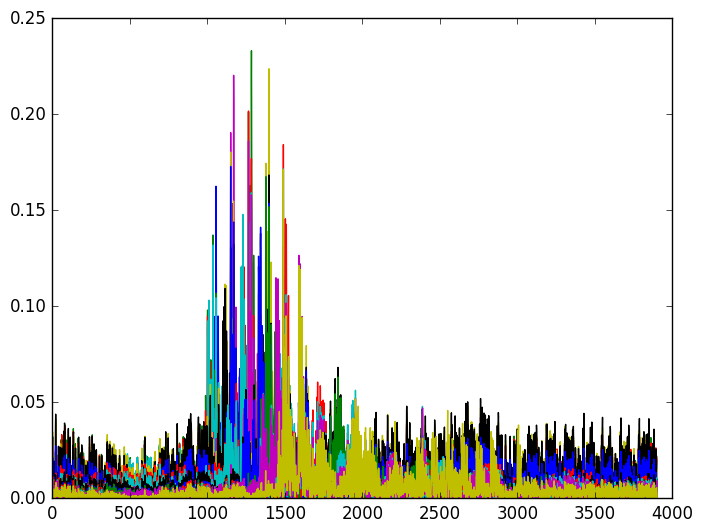

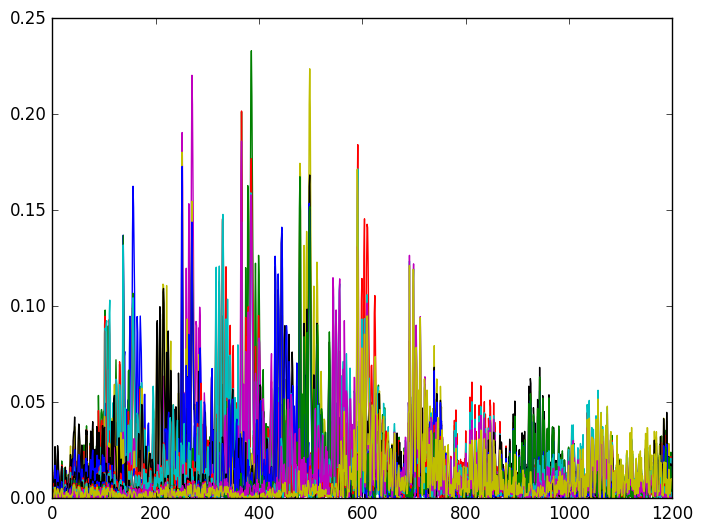

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7ff3af321790>)

In [8]:
# overall picture of HW input correlation
plot(C1')
figure()

# zoomed in
plot(C1[:,rangeOfInterest]')
figure()


Now let's find the output of the inner SHA1. We'll correlate with HW of 32-bits at the time to get a bit stronger signal. We'll find two peaks, one around sample 2100 and one near the end at 3500. The last one is (probably) caused by the outer SHA1 overwriting the inner SHA1 output. We'll use 900:2100 as the range for the inner SHA1 computation.

In [9]:
# byte-wise HW of inner SHA1 output correlated with samples
@everywhere begin
    addDataPass(trs, x -> inneroutput(innerstate,x[1:inputLength]))
    addDataPass(trs, x -> Sca.hw.(reinterpret(UInt32, x)))
    addSamplePass(trs, x -> abs.(x))
end

@time C2 = correlateDataSamples()

@everywhere begin
    popDataPass(trs)
    popDataPass(trs)
    popSamplePass(trs)
end


 56.704106 seconds (159.92 k allocations: 14.198 MiB)


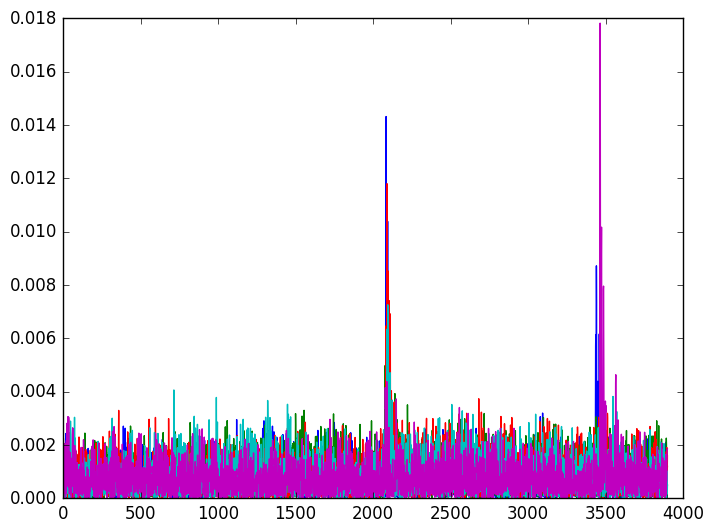

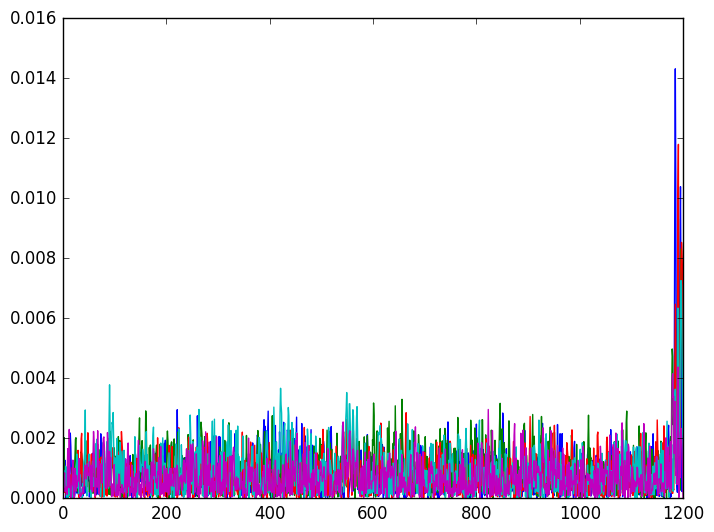

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x7ff3af122610>)

In [10]:
# overall picture of HW SHA1 output correlation
plot(C2')
figure()

# zoomed in
plot(C2[:,rangeOfInterest]')
figure()

Now we want to perform the attack described above. We'll use conditional averaging to speed things up. We will use Hamming weight as a leakage model, and store the correlation matrix for each attack. In total we'll get 20 correlation matrices, which we'll plot, marking the correlation of each correct hypothesis in red.

In [11]:
# call back for sca to dump the correlation data into a dictonary (hack, yes)
# we're just storing the pointers to correlation data in a global "corrMatrices"
function corrCb(c,keyOffsets)
    @assert length(params.analysis.leakages) == 1
    if length(keyOffsets) == 1
        keyOffset = keyOffsets[1]
        corrMatrices[keyOffset] = abs.(c)
    else
        for i in 1:length(keyOffsets)
            nrCands = getNumberOfCandidates(params)
            start = (i-1)*nrCands
            if isa(params.analysis, IncrementalCPA)
                corrMatrices[keyOffsets[i]] = abs.(@view c[:,start+1:start+nrCands])
            else
                corrMatrices[keyOffsets[i]] = abs.(c[i])
            end
        end
    end
end

corrCb (generic function with 1 method)

In [12]:
inccpa = false
params = Sha1InputAttack()
params.dataOffset = 1
params.knownKey = Nullable(knownkeyinner)
params.phases = collect(1:14)
params.xor = false
params.xorForT0 = 0x00000000
len = length(trs)

corrMatrices = Dict{Int, AbstractMatrix{Float64}}()


@everywhere addSamplePass(trs, x -> abs.(x))

if inccpa
    params.analysis = IncrementalCPA()
    @everywhere setPostProcessor(trs, IncrementalCorrelation(SplitByTracesBlock()))
else
    params.analysis = CPA()
    @everywhere setPostProcessor(trs, CondAvg(SplitByTracesBlock()))
end    

params.analysis.leakages = [HW()]

@time sca(DistributedTrace(), params, 1,len, false, Nullable{Function}(), Nullable{Function}(corrCb))

@everywhere popSamplePass(trs)



Jlsca running in Julia version: 0.6.0, 3 processes/2 workers/10 threads per worker

SHA1 input attack parameters
leakages:   Jlsca.Sca.Leakage[Jlsca.Sca.HW()]
input at:   1
known key:  685d79d6007d6cb9437d9393ce6eacdefbf69a0a

phase: 1

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:32ays



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 1
rank:   1, candidate: 0x00, peak: 0.981033 @ 1003
rank:   2, candidate: 0xe0, peak: 0.769999 @ 1113
rank:   3, candidate: 0x80, peak: 0.753968 @ 1023
rank:   4, candidate: 0x10, peak: 0.750532 @ 1059
rank: 106, correct  : 0x47, peak: 0.429055 @ 1395
recovered key material: 00

phase: 2
phase input: 47

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:26



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 2
rank:   1, candidate: 0x00, peak: 0.957738 @ 1011
rank:   2, candidate: 0x80, peak: 0.766702 @ 1057
rank:   3, candidate: 0xff, peak: 0.745644 @ 1164
rank:   4, candidate: 0xfc, peak: 0.648693 @ 1053
rank:  24, correct  : 0xcf, peak: 0.517212 @ 1396
recovered key material: 00

phase: 3
phase input: 47cf

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:29



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 3
rank:   1, candidate: 0xff, peak: 0.976921 @ 1037
rank:   2, candidate: 0x7f, peak: 0.850926 @ 1040
rank:   3, candidate: 0x03, peak: 0.769033 @ 1005
rank:   4, candidate: 0x01, peak: 0.725308 @ 1108
rank:  22, correct  : 0xa7, peak: 0.577220 @ 1396
recovered key material: ff

phase: 4
phase input: 47cfa7

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:27



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 4
rank:   1, candidate: 0xff, peak: 0.948149 @ 1038
rank:   2, candidate: 0x00, peak: 0.779104 @ 1039
rank:   3, candidate: 0x7f, peak: 0.703180 @ 1514
rank:   4, candidate: 0x3f, peak: 0.663101 @ 1166
rank:  37, correct  : 0x30, peak: 0.485279 @ 1284
recovered key material: ff

phase: 5
phase input: 47cfa730

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:25



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 5
rank:   1, candidate: 0x82, peak: 0.395792 @ 1395
rank:   2, correct  : 0x7e, peak: 0.383851 @ 1395
rank:   3, candidate: 0xfe, peak: 0.368506 @ 1395
rank:   4, candidate: 0x02, peak: 0.361301 @ 1396
rank:   5, candidate: 0x6f, peak: 0.302816 @ 2110
recovered key material: 82

phase: 6
phase input: 47cfa7307e

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:27



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 6
rank:   1, candidate: 0x81, peak: 0.374004 @ 1507
rank:   2, candidate: 0x02, peak: 0.343650 @ 1403
rank:   3, candidate: 0x03, peak: 0.341969 @ 1514
rank:   4, correct  : 0x01, peak: 0.340757 @ 1507
rank:   5, candidate: 0xb7, peak: 0.331639 @ 1397
recovered key material: 81

phase: 7
phase input: 47cfa7307e01

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:29



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 7
rank:   1, candidate: 0xaf, peak: 0.542707 @ 1507
rank:   2, correct  : 0x2f, peak: 0.541084 @ 1507
rank:   3, candidate: 0x47, peak: 0.452118 @ 1402
rank:   4, candidate: 0xb7, peak: 0.413424 @ 1397
rank:   5, candidate: 0x37, peak: 0.409728 @ 1397
recovered key material: af

phase: 8
phase input: 47cfa7307e012f

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:27



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 8
rank:   1, correct  : 0x6c, peak: 0.413656 @ 1507
rank:   2, candidate: 0xac, peak: 0.395613 @ 1284
rank:   3, candidate: 0x6b, peak: 0.388699 @ 1397
rank:   4, candidate: 0xec, peak: 0.378900 @ 1507
rank:   5, candidate: 0x2c, peak: 0.349997 @ 1283
recovered key material: 6c

phase: 9
phase input: 47cfa7307e012f6c

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:01:09



Averaged 1228800 input traces, UInt16 data type, Float64 sample type
CPA on samples shape (65536, 3900) (range 1:3900) and data shape (65536, 1)
CPA on samples shape (65536, 3900) (range 1:3900) and data shape (65536, 1)
CPA on samples shape (65536, 3900) (range 1:3900) and data shape (65536, 1)
CPA on samples shape (65536, 3900) (range 1:3900) and data shape (65536, 1)
Results @ 1228800 traces
kb: 9
rank:   1, candidate: 0xdc, peak: 0.035223 @ 1055
rank:   2, candidate: 0xdd, peak: 0.035196 @ 1055
rank:   3, candidate: 0x9c, peak: 0.034752 @ 1055
rank:   4, candidate: 0x9d, peak: 0.034725 @ 1055
rank: 187, correct  : 0x75, peak: 0.027769 @ 1055
kb: 10
rank:   1, candidate: 0x85, peak: 0.074679 @ 1057
rank:   2, candidate: 0x87, peak: 0.074390 @ 1057
rank:   3, candidate: 0x05, peak: 0.074343 @ 1057
rank:   4, candidate: 0x07, peak: 0.074055 @ 1057
rank:  96, correct  : 0x5e, peak: 0.069160 @ 1037
kb: 11
rank:   1, candidate: 0x7f, peak: 0.059667 @ 1507
rank:   2, candidate: 0xff, pea

Processing traces 1:1228800.. 100% Time: 0:00:50



Averaged 1228800 input traces, UInt16 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 13
rank:   1, candidate: 0x74, peak: 0.658454 @ 1041
rank:   2, candidate: 0x7c, peak: 0.632733 @ 1042
rank:   3, candidate: 0x34, peak: 0.603405 @ 1056
rank:   4, candidate: 0x3c, peak: 0.588227 @ 1041
rank:  44, correct  : 0x2e, peak: 0.459934 @ 1041
kb: 14
rank:   1, candidate: 0x78, peak: 0.603592 @ 1283
rank:   2, candidate: 0x52, peak: 0.594133 @ 1052
rank:   3, candidate: 0x58, peak: 0.573643 @ 1283
rank:   4, candidate: 0x53, peak: 0.566327 @ 1041
rank: 126, correct  : 0x5b, peak: 0.386376 @ 1401
kb: 15
rank:   1, candidate: 0x1b, peak: 0.779273 @ 1006
rank:   2, candidate: 0x19, peak: 0.749859 @ 1

Processing traces 1:1228800.. 100% Time: 0:00:25



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 17
rank:   1, candidate: 0x3b, peak: 0.320377 @ 3439
rank:   2, candidate: 0x2a, peak: 0.310413 @ 1401
rank:   3, correct  : 0x2c, peak: 0.307641 @ 1638
rank:   4, candidate: 0xaa, peak: 0.297215 @ 317
rank:   5, candidate: 0xbb, peak: 0.293976 @ 3440
recovered key material: 3b

phase: 12
phase input: 47cfa7307e012f6c755e179a2e5b1f402c

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:27



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 18
rank:   1, correct  : 0x0d, peak: 0.554265 @ 1632
rank:   2, candidate: 0x8d, peak: 0.433158 @ 1632
rank:   3, candidate: 0x0f, peak: 0.359247 @ 1633
rank:   4, candidate: 0x2d, peak: 0.350893 @ 1632
rank:   5, candidate: 0xed, peak: 0.321429 @ 1633
recovered key material: 0d

phase: 13
phase input: 47cfa7307e012f6c755e179a2e5b1f402c0d

	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:25



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 19
rank:   1, correct  : 0x00, peak: 0.504712 @ 1632
rank:   2, candidate: 0x80, peak: 0.456511 @ 1632
rank:   3, candidate: 0xfe, peak: 0.401987 @ 1638
rank:   4, candidate: 0x02, peak: 0.375757 @ 1638
rank:   5, candidate: 0x7e, peak: 0.336004 @ 1638
recovered key material: 00

phase: 14
phase input: 47cfa7307e012f6c755e179a2e5b1f402c0d00

	From worker 2:	Running processor Jlsca.Trs.CondAvg on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Trs.CondAvg on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:00:24



Averaged 1228800 input traces, UInt8 data type, Float64 sample type
CPA on samples shape (256, 3900) (range 1:3900) and data shape (256, 1)
Results @ 1228800 traces
kb: 20
rank:   1, correct  : 0x9e, peak: 0.520110 @ 1632
rank:   2, candidate: 0x1e, peak: 0.472652 @ 1632
rank:   3, candidate: 0xbe, peak: 0.388035 @ 1632
rank:   4, candidate: 0x3e, peak: 0.361609 @ 1632
rank:   5, candidate: 0xde, peak: 0.343894 @ 1632
recovered key material: 9e
recovered key: 91fe17724c6de1d3437d93a23f1176f9f23c006b
knownkey match: false
628.658532 seconds (27.30 M allocations: 56.612 GiB, 8.74% gc time)


In [13]:
# known round key data for all phases appended
rk = mapreduce(x -> get(Sca.getCorrectRoundKeyMaterial(params, x)), vcat, 1:14)

# plots a correlation matrix with the correct key in red
function kkPlot(axes,keyOffset, c, title)
    kb = Int(rk[keyOffset])
    (rows,cols) = size(c)

    for i in 1:256
        axes[:plot](c[rangeOfInterest,i], color="grey")
    end
    axes[:plot](c[rangeOfInterest,kb+1], color="red")
    axes[:set_title](title)

    figure()
end

# plot all the leakages in a grid: each row contains the 4 8-bit DPA attacks on a 32-bit modular addition 
# or Ch function (see intro text)
function plotAll()
    (fig,axes) = subplots(nrows=5, ncols=4, figsize=(12, 12), sharey=false)

    for keyOffset in sort(collect(keys(corrMatrices)))
        x = div((keyOffset-1), 4)
        y = (keyOffset-1) % 4
        dpa = x + 1
        lsb = y
        kkPlot(axes[x+1,y+1], keyOffset, corrMatrices[keyOffset], "dpa: $dpa, lsb: $lsb")
    end

    fig[:subplots_adjust](hspace=0.4)
end

plotAll (generic function with 1 method)

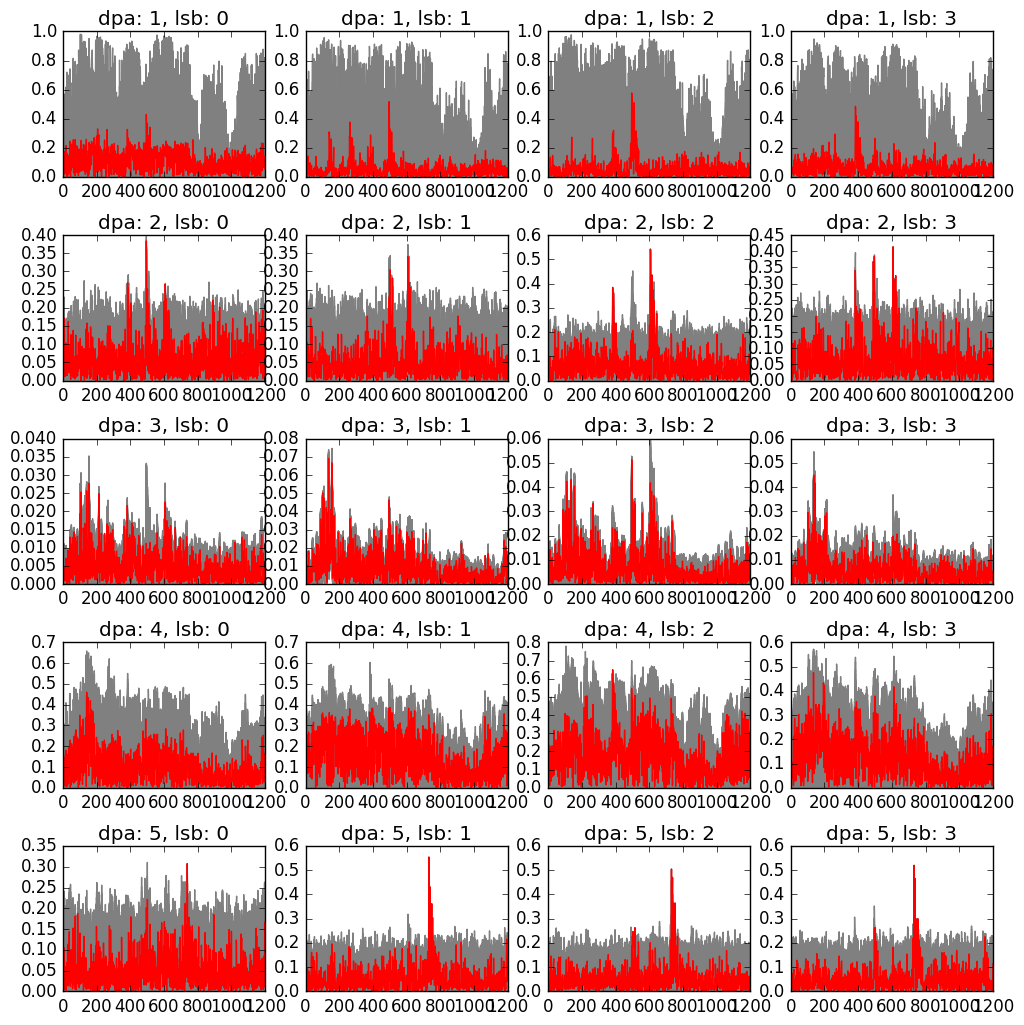

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [14]:
plotAll()

As you can see, it's not all bad for DPA 2 and 5. Unfortunately, the very first DPA 1 is not very good at all. Since all these DPA attacks depend on the success of the previous attack, it's not very hopeful. DPA 1 is bad because W0, the value under attacker control, is very similar to the predicted output T0. For the other DPA attacks this is not the case!

There turns out a way to make DPA 2 and 5 leak even better, and that's by exploiting the HD instead of the HW. For DPA 2, we'll predict HD(T0,T1) instead of HW(T1) and the DPA 5 HD(T1,T2) instead of HW(T2). This attack cannot be run with conditional averaging at the moment. Remember that previously each DPA on 32 bits actually is implemented by 4 DPA on 8-bits. With HD this changes, since each HD takes 16 bits input. This would mean that we end up with 65K different traces per intermediate input, which is currently ruining the conditional averaging code (my bad). Still, we can run this attack using incremental correlation, it just takes a bit longer.  Note that DPA attacks 1,3 and 4 are not using HD, that's because I don't know what the compute the HD with .. 

In [15]:
inccpa = true
params = Sha1InputAttack()
params.dataOffset = 1
params.knownKey = Nullable(knownkeyinner)
params.phases = collect(1:14)
params.xor = true
params.xorForT0 = 0x00000000
len = length(trs)

corrMatrices = Dict{Int, AbstractMatrix{Float64}}()

@everywhere addSamplePass(trs, x -> abs.(x))

if inccpa
    params.analysis = IncrementalCPA()
    @everywhere setPostProcessor(trs, IncrementalCorrelation(SplitByTracesBlock()))
else
    params.analysis = CPA()
    @everywhere setPostProcessor(trs, CondAvg(SplitByTracesBlock()))
end    

params.analysis.leakages = [HW()]

@time sca(DistributedTrace(), params, 1,len, false, Nullable{Function}(), Nullable{Function}(corrCb))

@everywhere popSamplePass(trs)



Jlsca running in Julia version: 0.6.0, 3 processes/2 workers/10 threads per worker

SHA1 input attack parameters
leakages:   Jlsca.Sca.Leakage[Jlsca.Sca.HW()]
input at:   1
known key:  685d79d6007d6cb9437d9393ce6eacdefbf69a0a

phase: 1

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:05:28


Results @ 1228800 traces
kb: 1
rank:   1, candidate: 0x00, peak: 0.132001 @ 1037
rank:   2, candidate: 0x10, peak: 0.096528 @ 1037
rank:   3, candidate: 0xf0, peak: 0.096020 @ 1037
rank:   4, candidate: 0xc0, peak: 0.095887 @ 1037
rank: 167, correct  : 0x47, peak: 0.028898 @ 1037
recovered key material: 00

phase: 2
phase input: 47

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:05:05


Results @ 1228800 traces
kb: 2
rank:   1, candidate: 0x00, peak: 0.093779 @ 1037
rank:   2, candidate: 0x80, peak: 0.072906 @ 1056
rank:   3, candidate: 0xff, peak: 0.070792 @ 1037
rank:   4, candidate: 0xfe, peak: 0.059443 @ 1055
rank: 218, correct  : 0xcf, peak: 0.012465 @ 1043
recovered key material: 00

phase: 3
phase input: 47cf

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:24


Results @ 1228800 traces
kb: 3
rank:   1, candidate: 0xff, peak: 0.124229 @ 1037
rank:   2, candidate: 0x7f, peak: 0.097198 @ 1037
rank:   3, candidate: 0xbf, peak: 0.077779 @ 1037
rank:   4, candidate: 0x00, peak: 0.076727 @ 1037
rank: 203, correct  : 0xa7, peak: 0.016415 @ 1396
recovered key material: ff

phase: 4
phase input: 47cfa7

	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:21


Results @ 1228800 traces
kb: 4
rank:   1, candidate: 0xff, peak: 0.136241 @ 1056
rank:   2, candidate: 0x00, peak: 0.110323 @ 1056
rank:   3, candidate: 0x7f, peak: 0.093147 @ 1056
rank:   4, candidate: 0xfe, peak: 0.081132 @ 1056
rank: 208, correct  : 0x30, peak: 0.014490 @ 1057
recovered key material: ff

phase: 5
phase input: 47cfa730

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:25


Results @ 1228800 traces
kb: 5
rank:   1, correct  : 0x7e, peak: 0.014311 @ 1283
rank:   2, candidate: 0x9e, peak: 0.011294 @ 1283
rank:   3, candidate: 0xbe, peak: 0.010922 @ 1283
rank:   4, candidate: 0xfe, peak: 0.010369 @ 1283
rank:   5, candidate: 0x5e, peak: 0.010300 @ 1283
recovered key material: 7e

phase: 6
phase input: 47cfa7307e

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:22


Results @ 1228800 traces
kb: 6
rank:   1, correct  : 0x01, peak: 0.020777 @ 1283
rank:   2, candidate: 0x81, peak: 0.015864 @ 1283
rank:   3, candidate: 0x05, peak: 0.012853 @ 1283
rank:   4, candidate: 0x41, peak: 0.012508 @ 1283
rank:   5, candidate: 0xc1, peak: 0.012074 @ 1283
recovered key material: 01

phase: 7
phase input: 47cfa7307e01

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:23


Results @ 1228800 traces
kb: 7
rank:   1, correct  : 0x2f, peak: 0.018240 @ 1283
rank:   2, candidate: 0xaf, peak: 0.013376 @ 1283
rank:   3, candidate: 0x4f, peak: 0.012585 @ 1283
rank:   4, candidate: 0x6f, peak: 0.012169 @ 1283
rank:   5, candidate: 0x0f, peak: 0.012119 @ 1283
recovered key material: 2f

phase: 8
phase input: 47cfa7307e012f

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:22


Results @ 1228800 traces
kb: 8
rank:   1, correct  : 0x6c, peak: 0.015136 @ 1283
rank:   2, candidate: 0xec, peak: 0.011806 @ 1283
rank:   3, candidate: 0x7c, peak: 0.011383 @ 1283
rank:   4, candidate: 0x8c, peak: 0.010957 @ 1283
rank:   5, candidate: 0x74, peak: 0.010156 @ 1283
recovered key material: 6c

phase: 9
phase input: 47cfa7307e012f6c

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:14:28


Results @ 1228800 traces
kb: 9
rank:   1, candidate: 0xdd, peak: 0.008966 @ 1055
rank:   2, candidate: 0xdc, peak: 0.008909 @ 1055
rank:   3, candidate: 0x9d, peak: 0.008779 @ 1055
rank:   4, candidate: 0xdf, peak: 0.008727 @ 1055
rank: 175, correct  : 0x75, peak: 0.006980 @ 1055
kb: 10
rank:   1, candidate: 0x9f, peak: 0.019325 @ 1037
rank:   2, candidate: 0x1f, peak: 0.019164 @ 1037
rank:   3, candidate: 0x9b, peak: 0.019100 @ 1037
rank:   4, candidate: 0x17, peak: 0.018938 @ 1056
rank:  49, correct  : 0x5e, peak: 0.018263 @ 1037
kb: 11
rank:   1, candidate: 0x7f, peak: 0.014573 @ 1507
rank:   2, candidate: 0xff, peak: 0.014548 @ 1507
rank:   3, candidate: 0x5f, peak: 0.014075 @ 1507
rank:   4, candidate: 0xdf, peak: 0.014051 @ 1507
rank:  54, correct  : 0x17, peak: 0.012179 @ 1396
kb: 12
rank:   1, candidate: 0x84, peak: 0.015244 @ 1037
rank:   2, candidate: 0xa4, peak: 0.015240 @ 1037
rank:   3, candidate: 0xc4, peak: 0.015187 @ 1037
rank:   4, candidate: 0xe4, peak: 0.015186 @ 103

Processing traces 1:1228800.. 100% Time: 0:14:28


Results @ 1228800 traces
kb: 13
rank:   1, candidate: 0x74, peak: 0.094978 @ 1037
rank:   2, candidate: 0x34, peak: 0.080249 @ 1037
rank:   3, candidate: 0x76, peak: 0.068531 @ 1037
rank:   4, candidate: 0x36, peak: 0.066637 @ 1037
rank:  49, correct  : 0x2e, peak: 0.040402 @ 1037
kb: 14
rank:   1, candidate: 0x53, peak: 0.046637 @ 1037
rank:   2, candidate: 0x51, peak: 0.046500 @ 1037
rank:   3, candidate: 0x52, peak: 0.044440 @ 1037
rank:   4, candidate: 0x50, peak: 0.043342 @ 1037
rank:  31, correct  : 0x5b, peak: 0.030732 @ 1002
kb: 15
rank:   1, candidate: 0x38, peak: 0.081744 @ 1037
rank:   2, candidate: 0x78, peak: 0.079819 @ 1037
rank:   3, candidate: 0xb8, peak: 0.079452 @ 1037
rank:   4, candidate: 0xf8, peak: 0.078377 @ 1037
rank: 203, correct  : 0x1f, peak: 0.039077 @ 1037
kb: 16
rank:   1, candidate: 0xd2, peak: 0.066894 @ 1056
rank:   2, candidate: 0xd0, peak: 0.066571 @ 1056
rank:   3, candidate: 0xd1, peak: 0.066048 @ 1056
rank:   4, candidate: 0x51, peak: 0.065045 @ 10

Processing traces 1:1228800.. 100% Time: 0:04:24


Results @ 1228800 traces
kb: 17
rank:   1, correct  : 0x2c, peak: 0.015550 @ 1396
rank:   2, candidate: 0xac, peak: 0.011099 @ 1396
rank:   3, candidate: 0xec, peak: 0.010717 @ 1396
rank:   4, candidate: 0x6c, peak: 0.010054 @ 1396
rank:   5, candidate: 0x34, peak: 0.009568 @ 1396
recovered key material: 2c

phase: 12
phase input: 47cfa7307e012f6c755e179a2e5b1f402c

	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes
	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:23


Results @ 1228800 traces
kb: 18
rank:   1, correct  : 0x0d, peak: 0.018636 @ 1396
rank:   2, candidate: 0x8d, peak: 0.014295 @ 1396
rank:   3, candidate: 0x0f, peak: 0.012822 @ 1396
rank:   4, candidate: 0x4d, peak: 0.012762 @ 1396
rank:   5, candidate: 0x0e, peak: 0.011507 @ 1395
recovered key material: 0d

phase: 13
phase input: 47cfa7307e012f6c755e179a2e5b1f402c0d

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:23


Results @ 1228800 traces
kb: 19
rank:   1, correct  : 0x00, peak: 0.018741 @ 1396
rank:   2, candidate: 0x80, peak: 0.014888 @ 1396
rank:   3, candidate: 0xc0, peak: 0.013032 @ 1396
rank:   4, candidate: 0x40, peak: 0.012827 @ 1396
rank:   5, candidate: 0x20, peak: 0.010789 @ 1396
recovered key material: 00

phase: 14
phase input: 47cfa7307e012f6c755e179a2e5b1f402c0d00

	From worker 2:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 1:1:614400, using trace set with 2 data passes, 2 sample passes
	From worker 3:	Running processor Jlsca.Sca.IncrementalCorrelation on trace range 614401:1:1228800, using trace set with 2 data passes, 2 sample passes


Processing traces 1:1228800.. 100% Time: 0:04:24


Results @ 1228800 traces
kb: 20
rank:   1, correct  : 0x9e, peak: 0.016637 @ 1396
rank:   2, candidate: 0x1e, peak: 0.015589 @ 1396
rank:   3, candidate: 0xde, peak: 0.012067 @ 1396
rank:   4, candidate: 0x5e, peak: 0.012067 @ 1396
rank:   5, candidate: 0x3e, peak: 0.010385 @ 1396
recovered key material: 9e
recovered key: 11fe7f7648e14dd3437d9393bf72b3f06e38e3f2
knownkey match: false
5007.499817 seconds (8.59 M allocations: 2.038 GiB, 0.04% gc time)


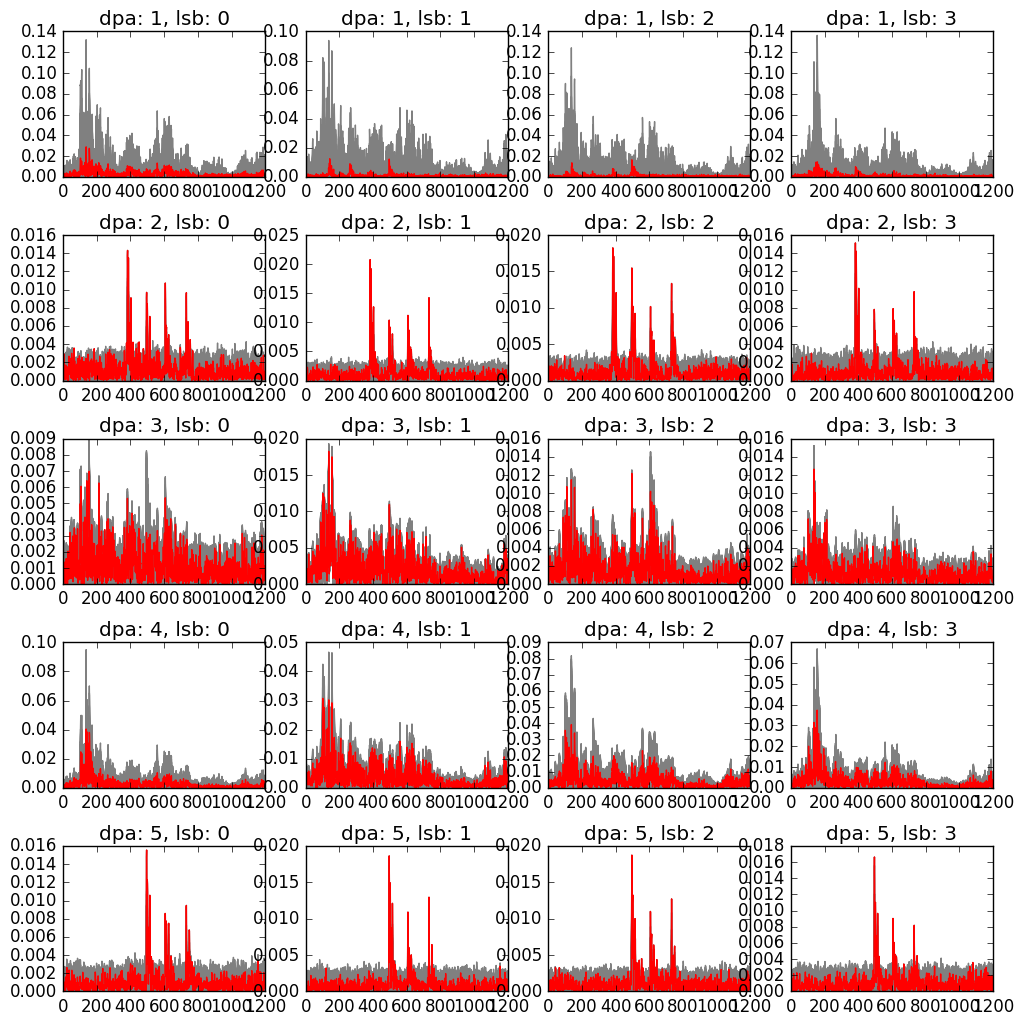

In [16]:
plotAll()